# TP Prédiction des prix de voitures d'occasions

L'objectif va être de **prédire le prix de voitures usées**. Pour cela, on va devoir **analyser et adapter les features disponibles** afin d'entrraîner le modèle final. 

On va utiliser le dataset suivant : [Used Car Price Prediction Dataset](https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset)

In [20]:
# Install dependencies, download and unzip the data.

# !pip install kaggle pandas numpy matplotlib scikit-learn
# !kaggle datasets download taeefnajib/used-car-price-prediction-dataset
# !unzip used-car-price-prediction-dataset.zip
# !rm used-car-price-prediction-dataset.zip

On commence par charger les données. Je retire quelques features qui ne sont pas utilisées, dans un premier temps.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv("used_cars.csv")

df = df.drop(columns=["ext_col", "int_col"])

print(f"Number of cars: {len(df)}")
df.head()

Number of cars: 4009


,brand,model,model_year,milage,fuel_type,engine,transmission,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,None reported,NaN,"$34,999"


# Checking the Null values of all the Columns in the dataset

In [22]:
df.isnull().sum()   

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
accident        113
clean_title     596
price             0
dtype: int64

# Préparation des données 

L’objectif de cette étape est de transformer les données brutes du dataset en variables numériques exploitables par les modèles de machine learning.

- 1. Nettoyage des colonnes numériques (milage, price)
Suppression des caractères non numériques (,, $, mi.).
Conversion des colonnes en type float.

- 2. Conversion des valeurs catégorielles en valeurs numériques

**Colonne accident**

"None reported" → 0
Toute autre valeur (accident signalé) → 1

**Colonne clean_title**

"Yes" → 1
"No" ou autres → 0

**Colonne transmission**

"Automatic" → 1
"Manual" → 0

- 3. Extraction et conversion des caractéristiques techniques (moteur, carburant)

**Colonne engine**

Extraction des valeurs numériques (ex : “3.5L” → 3.5) à l’aide d’expressions régulières.
Conversion en type float.

**Colonne fuel_type**

Mise en minuscule, suppression des espaces.
Standardisation des valeurs (gasoline → gas, flex fuel → flex, etc.).
Encodage numérique (fuel_type_encoded).

- 4. Ajout d’une nouvelle variable : âge du véhicule

Création de la colonne year_used = année_actuelle - model_year

- 5. Encodage des marques et modèles (Target Encoding)

**Marque (brand) :**

Conversion en minuscule, nettoyage.
Calcul du prix moyen par marque.
Encodage dans une nouvelle colonne brand_encoded.

**Modèle (model) :**

Extraction du premier mot (ex : “F-150 XL” → “f-150”).
Calcul du prix moyen par modèle.
Encodage dans model_encoded.

- 6. Suppression des valeurs aberrantes (outliers)
Suppression des 1% des prix les plus bas et des 1% les plus élevés (quantile 0.01 – 0.99)
Cela permet de stabiliser l’entraînement des modèles.

In [23]:
# Imports

import re
import datetime


# 1) Nettoyage des strings = numériques

# milage
df["milage"] = df["milage"].apply(lambda x: x.replace(",", ""))
df["milage"] = df["milage"].apply(lambda x: x.replace(" mi.", ""))
df["milage"] = df["milage"].astype(float)

# price
df["price"] = df["price"].apply(lambda x: x.replace(",", ""))
df["price"] = df["price"].apply(lambda x: x.replace("$", ""))
df["price"] = df["price"].astype(float)

# 2) Encodages binaires simples

# accident
df["accident"] = (df["accident"] != "None reported").astype(int)

# clean_title
df["clean_title"] = df["clean_title"].apply(lambda x: 1 if x == "Yes" else 0).astype(int)

# transmission
df["transmission"] = df["transmission"].apply(lambda x: 1 if x == "Automatic" else 0).astype(int)


# 3) Features dérivées

# year_used
curr_time = datetime.datetime.now()
df["year_used"] = df["model_year"].apply(lambda x: curr_time.year - x)

# engine (extraction en L)
re_pattern = r'([0-9]+(?:\.[0-9]+)?)\s*L'
df["engine"] = df["engine"].apply(
    lambda x: re.search(re_pattern, x).group(1) if re.search(re_pattern, x) else None
)
df["engine"] = df["engine"].astype(float)
df = df.dropna(subset=["engine"])


# 4) fuel_type : nettoyage + mapping numérique

df["fuel_type"] = df["fuel_type"].astype(str).str.lower().str.strip()

# Harmonisation des libellés
df["fuel_type"] = df["fuel_type"].replace({
    "gasoline": "gas",
    "petrol": "gas",
    "flex fuel": "flex",
    "e85 flex fuel": "flex",
    "diesel": "diesel",
    "hybrid": "hybrid",
    "electric": "electric",
})

# Autres catégories = "other"
df["fuel_type"] = df["fuel_type"].apply(
    lambda x: x if x in ["gas", "diesel", "hybrid", "electric", "flex"] else "other"
)

# Encodage numérique (conserve l'ordre d'apparition)
fuel_mapping = {fuel: idx for idx, fuel in enumerate(df["fuel_type"].unique())}
df["fuel_type_encoded"] = df["fuel_type"].map(fuel_mapping)

print(df[["fuel_type", "fuel_type_encoded"]].head())
print("Mapping carburant utilisé :", fuel_mapping)


# 5) model : simplification + target encoding

df["model"] = df["model"].astype(str).str.lower().str.strip()
df["model_simple"] = df["model"].str.split().str[0]

model_mean_price = df.groupby("model_simple")["price"].mean()
df["model_encoded"] = df["model_simple"].map(model_mean_price).fillna(0)


# 6) brand : nettoyage + target encoding

df["brand"] = df["brand"].astype(str).str.lower().str.strip()

brand_mean_price = df.groupby("brand")["price"].mean()
df["brand_encoded"] = df["brand"].map(brand_mean_price)
df["brand_encoded"] = df["brand_encoded"].fillna(0)

print(df[["brand", "brand_encoded"]].head())


# 7) Suppression des outliers prix (1% bas / 1% haut)

lower_bound, upper_bound = df["price"].quantile([0.01, 0.99])
df_clean = df[(df["price"] >= lower_bound) & (df["price"] <= upper_bound)]

print(f"Nombre de lignes avant : {len(df)}")
print(f"Nombre de lignes après suppression des outliers : {len(df_clean)}")
print(f"Données conservées : {len(df_clean)/len(df)*100:.2f}%")

# Remplacer df par la version nettoyé
df = df_clean


  fuel_type  fuel_type_encoded
0      flex                  0
1       gas                  1
2       gas                  1
3    hybrid                  2
4       gas                  1
Mapping carburant utilisé : {'flex': 0, 'gas': 1, 'hybrid': 2, 'diesel': 3, 'other': 4}
      brand  brand_encoded
0      ford   35606.737127
1   hyundai   18434.434783
2     lexus   35668.521472
3  infiniti   22927.644068
4      audi   39783.494845
Nombre de lignes avant : 3792
Nombre de lignes après suppression des outliers : 3720
Données conservées : 98.10%


In [24]:
df.drop(['brand','model','model_simple','model_year', 'fuel_type'],axis=1,inplace=True)

In [25]:
print(df.dtypes)
df.head()

milage               float64
engine               float64
transmission           int64
accident               int64
clean_title            int64
price                float64
year_used              int64
fuel_type_encoded      int64
model_encoded        float64
brand_encoded        float64
dtype: object


,milage,engine,transmission,accident,clean_title,price,year_used,fuel_type_encoded,model_encoded,brand_encoded
0,51000.0,3.7,0,1,1,10300.0,12,0,10633.333333,35606.737127
1,34742.0,3.8,0,1,1,38005.0,4,1,38461.000000,18434.434783
2,22372.0,3.5,1,0,0,54598.0,3,1,31932.575758,35668.521472
3,88900.0,3.5,0,0,1,15500.0,10,2,22794.250000,22927.644068
4,9835.0,2.0,0,0,0,34999.0,4,1,30526.750000,39783.494845


In [26]:
df.isnull().sum()

milage               0
engine               0
transmission         0
accident             0
clean_title          0
price                0
year_used            0
fuel_type_encoded    0
model_encoded        0
brand_encoded        0
dtype: int64

## Exploration et analyse des données (EDA)

Maintenant que les données sont sous forme numérique, on peut commencer à explorer un peu à quoi elles ressemblent.

Cette étape est couramment appelée *Exploratory Data Analysis* (EDA).
Elle permet de mieux comprendre nos données et de savoir quelles transformations on va vouloir appliquer avant d'entraîner notre modèle.

- Affichez les distributions de chaque features et du prix.
- Qu'en concluez-vous ?
- Quelles sont les transformations que l'on pourrait appliquer ?

---

- Affichez ensuite un *scatter plot* de chaque feature en fonction du prix de la voiture.
- Quelles sont les features les plus prometteuses ?

*N'hésitez pas à appliquer des transformations sur les données avant de faire les scatter plot afin d'y voir plus clair.*

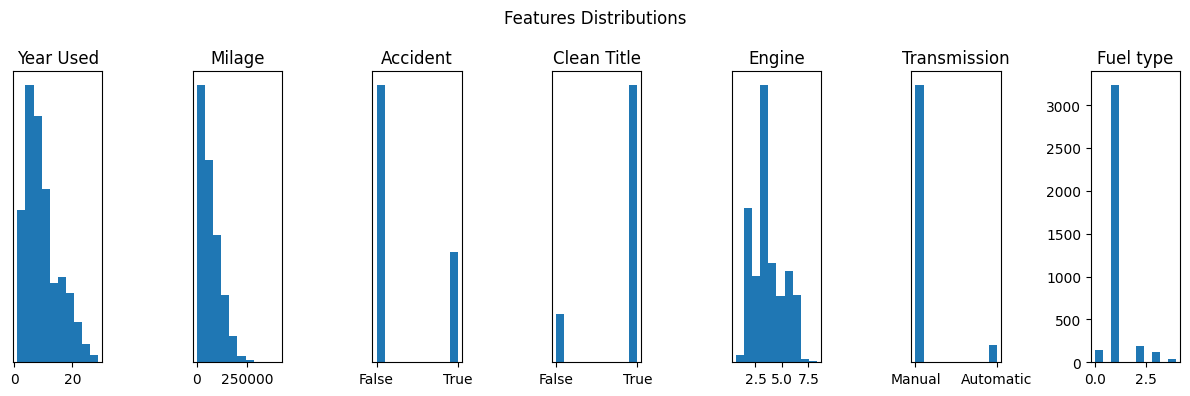

In [27]:
fig, axs = plt.subplots(1, 7, figsize=(12, 4))

axs[0].hist(df["year_used"])
axs[0].set_title("Year Used")
axs[0].yaxis.set_visible(False)

axs[1].hist(df["milage"])
axs[1].set_title("Milage")
axs[1].yaxis.set_visible(False)

axs[2].hist(df["accident"])
axs[2].set_title("Accident")
axs[2].yaxis.set_visible(False)
axs[2].set_xticks([0, 1], labels=["False", "True"])

axs[3].hist(df["clean_title"])
axs[3].set_title("Clean Title")
axs[3].yaxis.set_visible(False)
axs[3].set_xticks([0, 1], labels=["False", "True"])

axs[4].hist(df["engine"])
axs[4].set_title("Engine")
axs[4].yaxis.set_visible(False)

axs[5].hist(df["transmission"])
axs[5].set_title("Transmission")
axs[5].yaxis.set_visible(False)
axs[5].set_xticks([0, 1], labels=["Manual", "Automatic"])

axs[6].hist(df["fuel_type_encoded"])
axs[6].set_title("Fuel type")


fig.suptitle("Features Distributions")
fig.tight_layout()

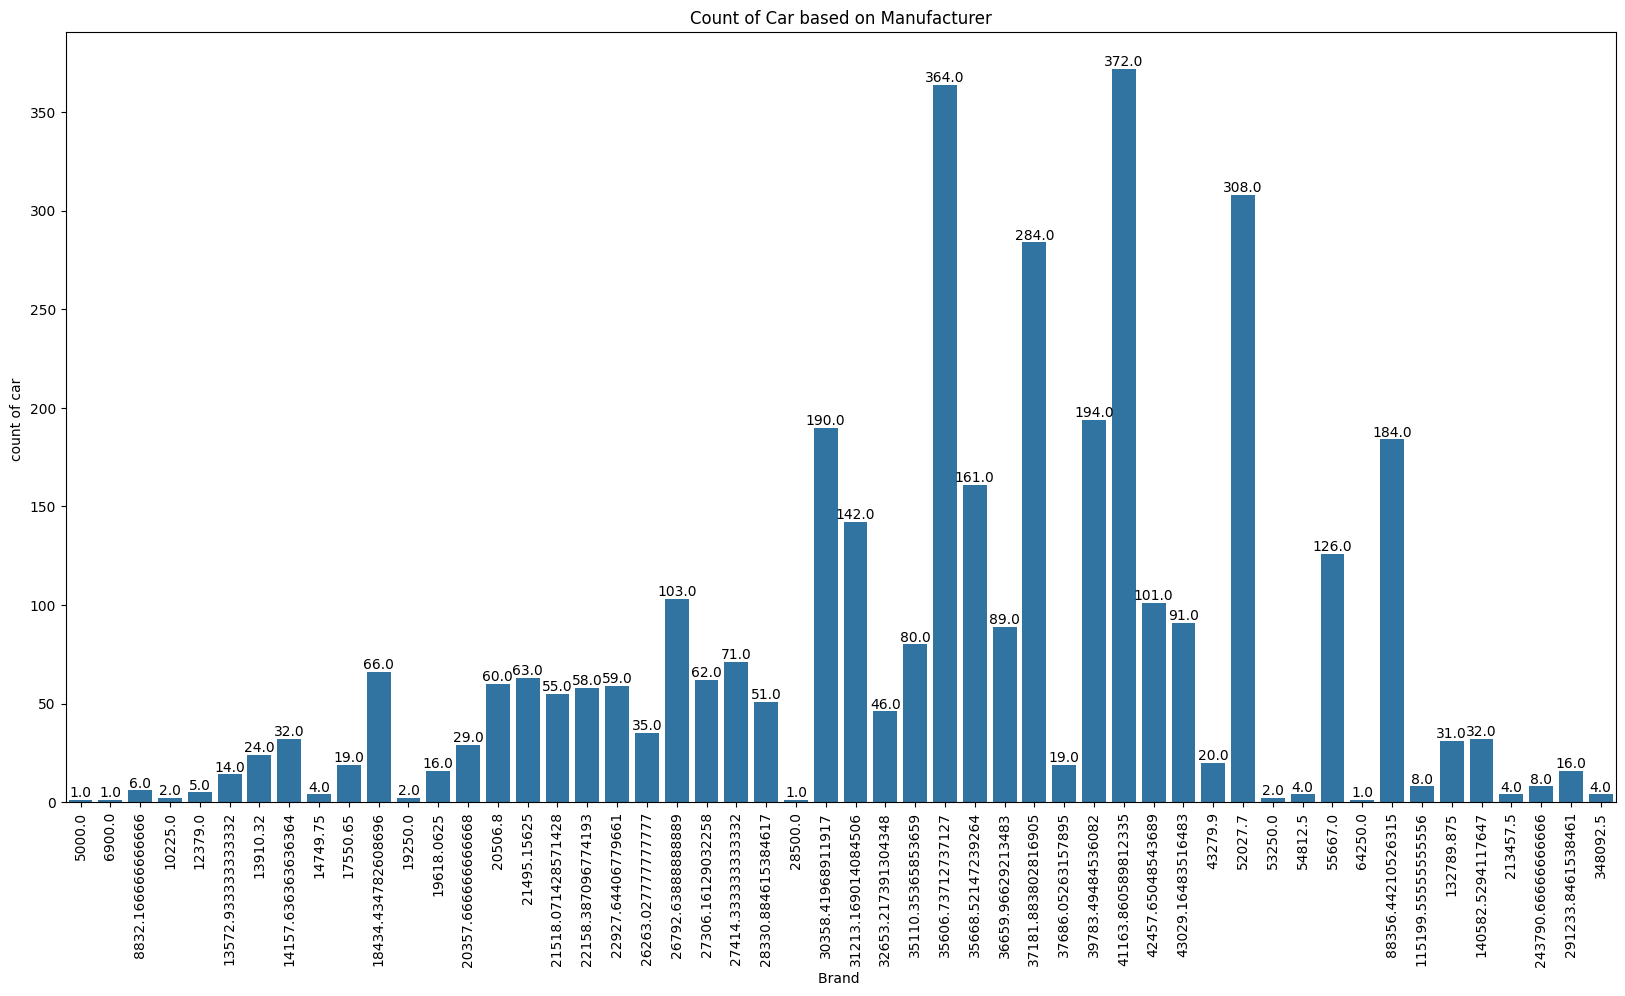

In [28]:
import seaborn as sns
df_copy = pd.read_csv("used_cars.csv")

plt.rcParams['figure.figsize']=(20,10)
plot = sns.countplot(x='brand_encoded',data = df)
plt.xticks(rotation=90)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x()+p.get_width()/2.0,p.get_height()),
                  ha='center',va='center',xytext=(0,5),textcoords='offset points')
plt.title('Count of Car based on Manufacturer')
plt.xlabel('Brand \
')
plt.ylabel('count of car ')
plt.savefig('Count of Car.png')
plt.show()

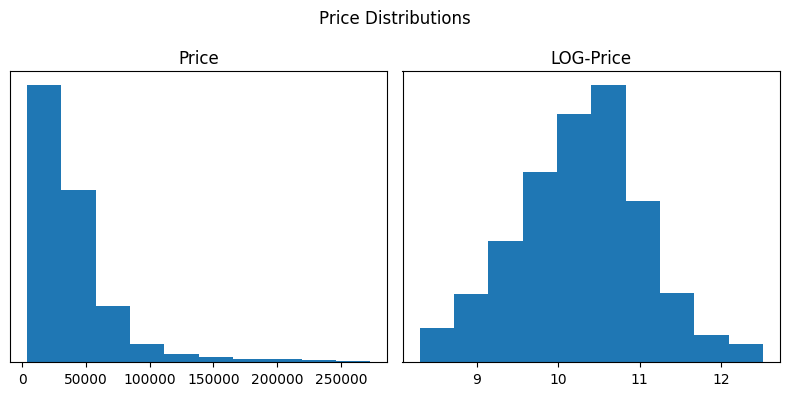

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].hist(df["price"])
axs[0].set_title("Price")
axs[0].yaxis.set_visible(False)

log_price = np.log(df["price"])
axs[1].hist(log_price)
axs[1].set_title("LOG-Price")
axs[1].yaxis.set_visible(False)

fig.suptitle("Price Distributions")
fig.tight_layout()

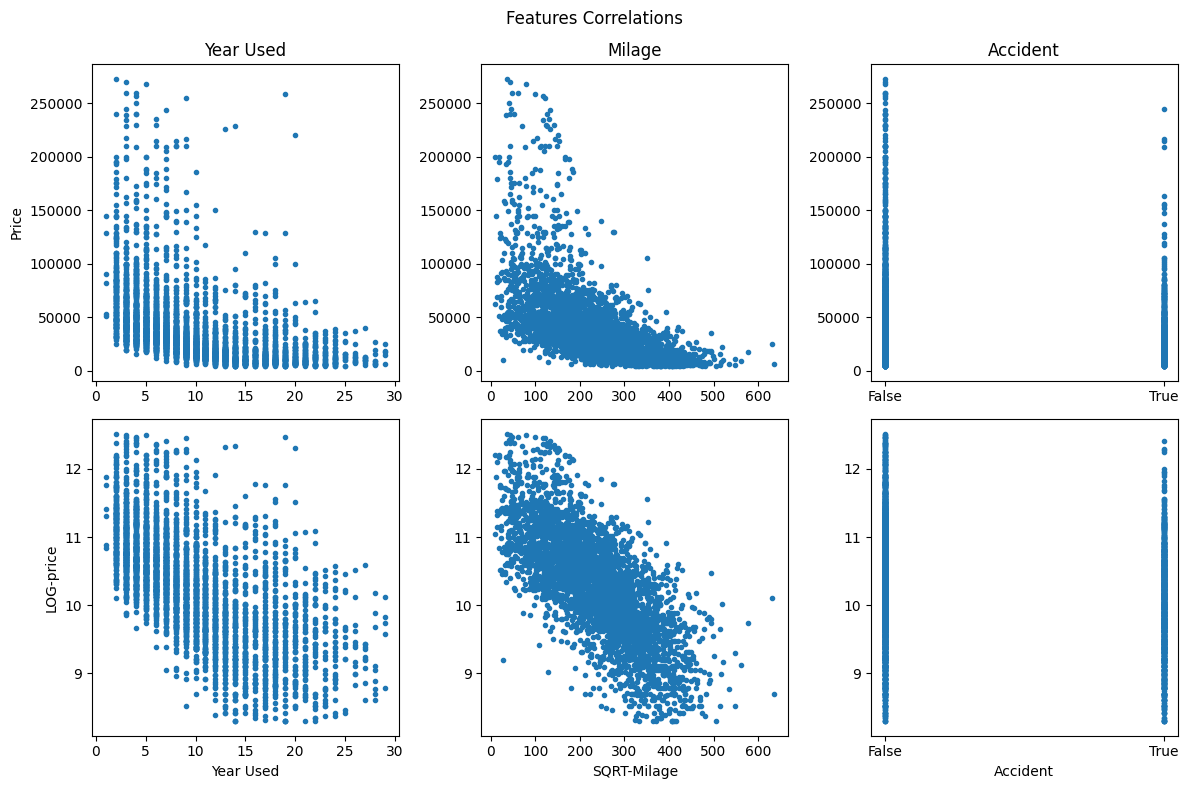

In [30]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
log_price = np.log(df["price"])

# axs[0, 0].plot(df["model_year"], df["price"], '.')
# axs[1, 0].plot(df["model_year"], log_price, '.')
# axs[0, 0].set_title("Model Year")
# axs[1, 0].set_xlabel("Model Year")
axs[0, 0].plot(df["year_used"], df["price"], '.')
axs[1, 0].plot(df["year_used"], log_price, '.')
axs[0, 0].set_title("Year Used")
axs[1, 0].set_xlabel("Year Used")
axs[0, 0].set_ylabel("Price")
axs[1, 0].set_ylabel("LOG-price")

axs[0, 1].plot(np.sqrt(df["milage"]), df["price"], '.')
axs[1, 1].plot(np.sqrt(df["milage"]), log_price, '.')
axs[0, 1].set_title("Milage")
axs[1, 1].set_xlabel("SQRT-Milage")

axs[0, 2].plot(df["accident"], df["price"], '.')
axs[1, 2].plot(df["accident"], log_price, '.')
axs[0, 2].set_title("Accident")
axs[1, 2].set_xlabel("Accident")
axs[0, 2].set_xticks([0, 1], labels=["False", "True"])
axs[1, 2].set_xticks([0, 1], labels=["False", "True"])


fig.suptitle("Features Correlations")
fig.tight_layout()

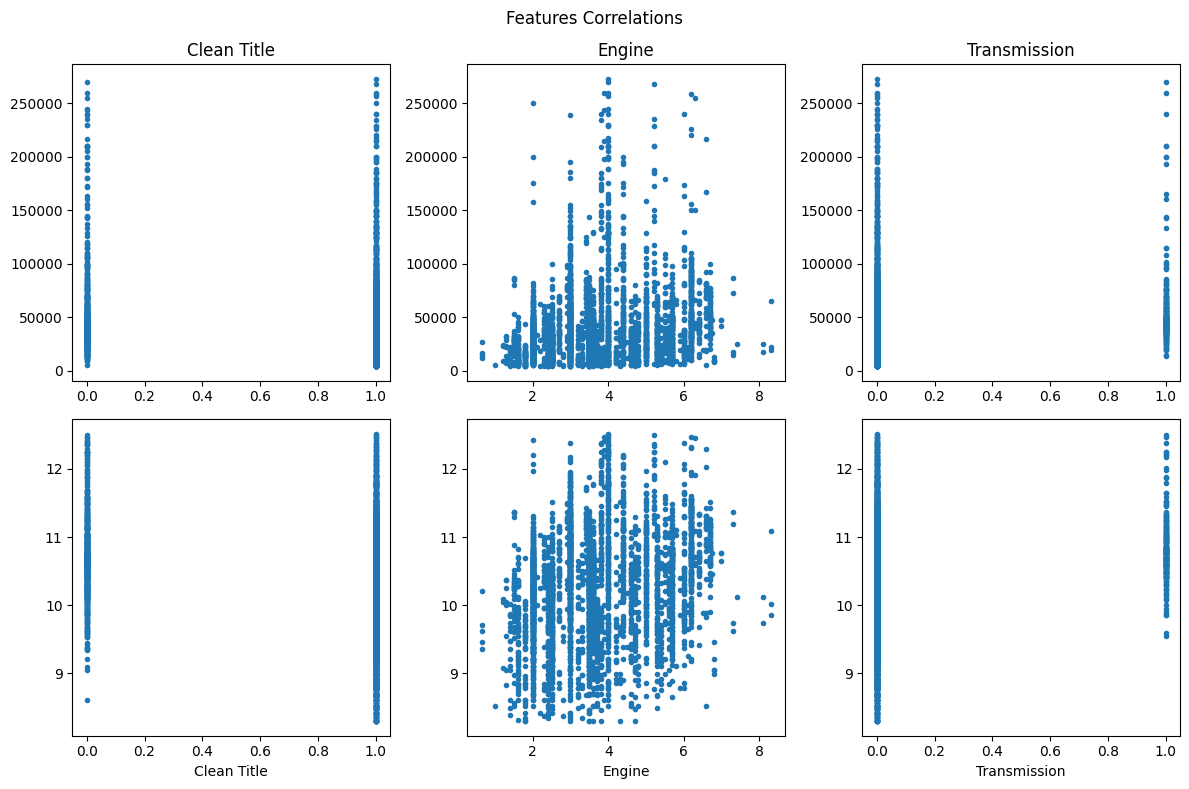

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
log_price = np.log(df["price"])

axs[0, 0].plot(df["clean_title"], df["price"], '.')
axs[1, 0].plot(df["clean_title"], log_price, '.')
axs[0, 0].set_title("Clean Title")
axs[1, 0].set_xlabel("Clean Title")

axs[0, 1].plot(df["engine"], df["price"], '.')  
axs[1, 1].plot(df["engine"], log_price, '.')
axs[0, 1].set_title("Engine")
axs[1, 1].set_xlabel("Engine")

axs[0, 2].plot(df["transmission"], df["price"], '.')
axs[1, 2].plot(df["transmission"], log_price, '.')
axs[0, 2].set_title("Transmission")
axs[1, 2].set_xlabel("Transmission")

fig.suptitle("Features Correlations")
fig.tight_layout()

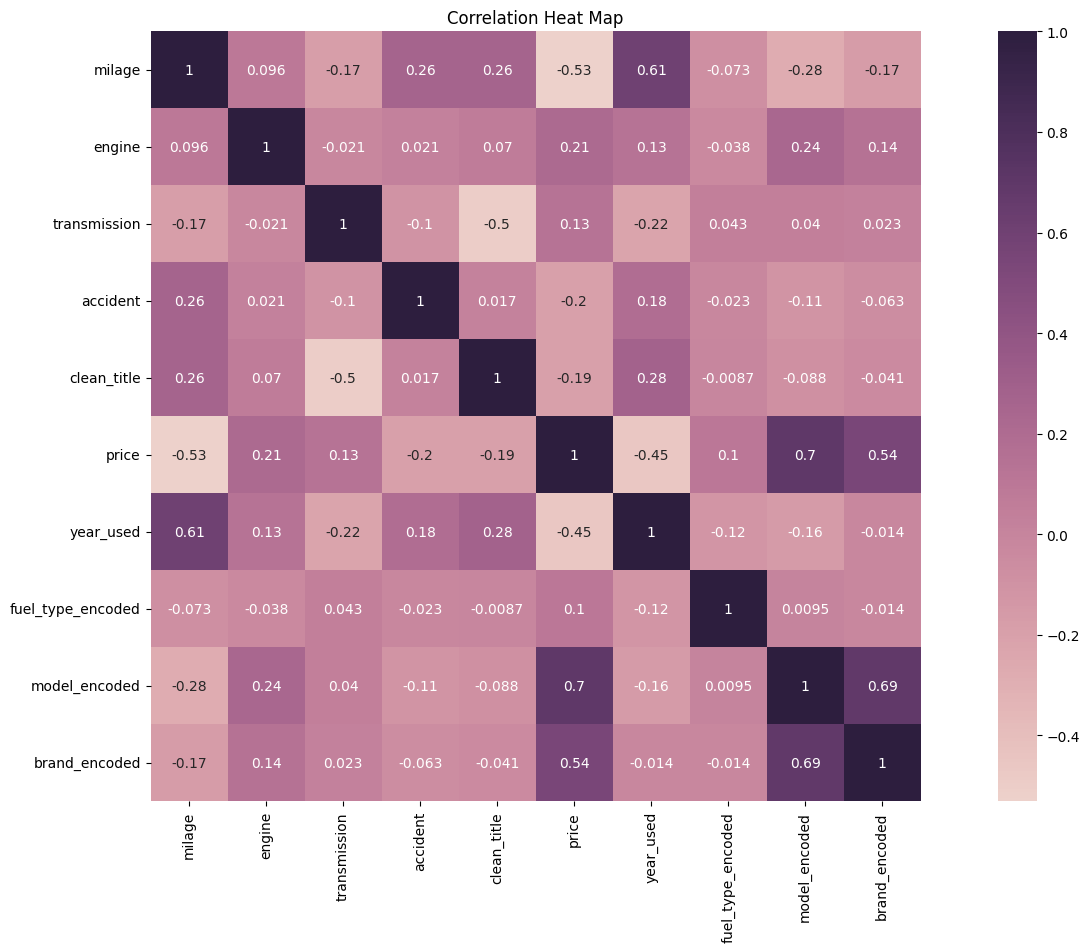

In [32]:
corr = df.corr()
sns.heatmap(corr,annot=True,cmap = sns.cubehelix_palette(as_cmap=True),cbar=True,square=True)
plt.title('Correlation Heat Map')
plt.savefig('Correlation Heat Map.png')
plt.show()

# Data preprocessing

In [33]:
# Data normalization.
milage = np.sqrt(df["milage"].values)
milage = (milage - np.min(milage)) / (np.max(milage) - np.min(milage))
# model_year = df["model_year"].values
# model_year = (model_year - np.min(model_year)) / (np.max(model_year) - np.min(model_year))
year_used = df["year_used"].values
year_used = (year_used - np.min(year_used)) / (np.max(year_used) - np.min(year_used))
accident = df["accident"].values
clean_title = df["clean_title"].values
engine = df["engine"].values
engine = (engine - np.min(engine)) / (np.max(engine) - np.min(engine))
transmission = df["transmission"].values
fuel_type = df["fuel_type_encoded"].values
brand = df["brand_encoded"].values
brand = (brand - np.min(brand)) / (np.max(brand) - np.min(brand))
model = df["model_encoded"].values
model = (model - np.min(model)) / (np.max(model) - np.min(model))

X = np.stack((brand, model, milage, year_used, accident, clean_title, engine, transmission), axis=1)
print("X shape:", X.shape)

y = df["price"].values
y = np.log(y)
mean_y, std_y = np.mean(y), np.std(y)
y = (y - mean_y) / std_y
y = y.reshape(-1, 1)
print("y shape:", y.shape)

X shape: (3720, 8)
y shape: (3720, 1)


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=45)

print('X_train',x_train.shape)
print('X_test',x_test.shape)

sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.fit_transform(x_test)

X_train (2604, 8)
X_test (1116, 8)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt

def FitModel(x,y,algo_name,algorithm,gridSearchParams,cv):
    np.random.seed(10)
    grid = GridSearchCV(estimator=algorithm,param_grid=gridSearchParams,scoring='r2',verbose=0,cv=cv,n_jobs=-1)
    grid_result = grid.fit(x_train,y_train)
    best_params = grid_result.best_params_
    y_pred = grid_result.predict(x_test)
    print(' Algorithm Name:',algo_name)
    print('\n Best Params:',best_params)
    print('\n R2 Score:{}%'.format(100*r2_score(y_test,y_pred)))
    print('\n Mean Absolute Error:',mean_absolute_error(y_test,y_pred))
    print('\n Mean Squared Error:',mean_squared_error(y_test,y_pred))
    print('\n Root Mean Squared Error:',sqrt(mean_squared_error(y_test,y_pred)))

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(y_pred, y_test, '.')
    ax.plot(y_test, y_test, '.', color="red")
    ax.set_title("predictions vs réel")
    ax.set_xlabel("Predictions")
    ax.set_ylabel("Réel")
    fig.tight_layout()
    plt.show()

# Régression Linéaire

 Algorithm Name: Linear Regression

 Best Params: {}

 R2 Score:80.77178496864053%

 Mean Absolute Error: 0.32043740033153945

 Mean Squared Error: 0.18613302673211887

 Root Mean Squared Error: 0.431431369666276


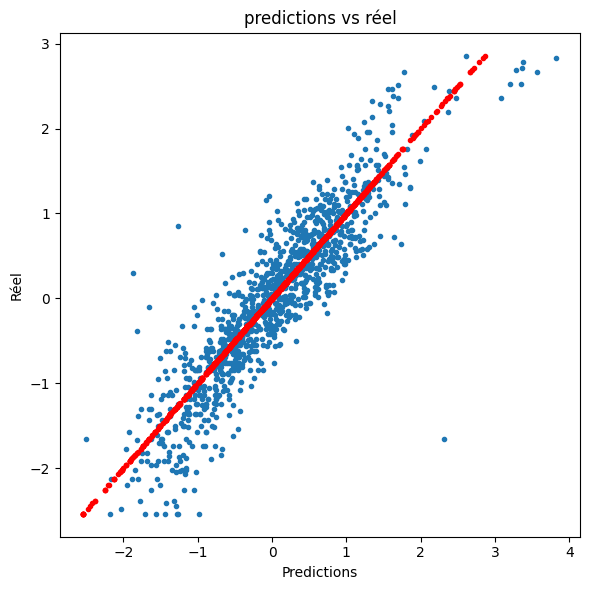

In [36]:
params = {}
FitModel(X,y,'Linear Regression',LinearRegression(),params,cv=10)

# Model Random Forest Regressor

C:\Users\astri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


 Algorithm Name: Random Forest

 Best Params: {'n_estimators': 314, 'random_state': 45}

 R2 Score:88.31507573749877%

 Mean Absolute Error: 0.24333859683776182

 Mean Squared Error: 0.11311244005581264

 Root Mean Squared Error: 0.33632192919257087


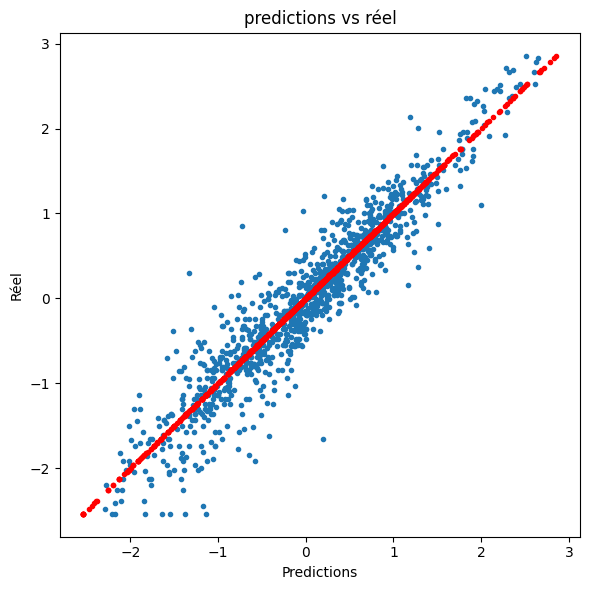

In [37]:
from sklearn.ensemble import RandomForestRegressor

params = {'n_estimators':[44,109,314],
         'random_state':[45]}
FitModel(X,y,'Random Forest',RandomForestRegressor(),params,cv=10)

# Extra Tree

C:\Users\astri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


 Algorithm Name: Extra Tree

 Best Params: {'n_estimators': 314, 'random_state': 45}

 R2 Score:88.74414526829636%

 Mean Absolute Error: 0.2408603109537129

 Mean Squared Error: 0.10895895985415928

 Root Mean Squared Error: 0.33008932102411204


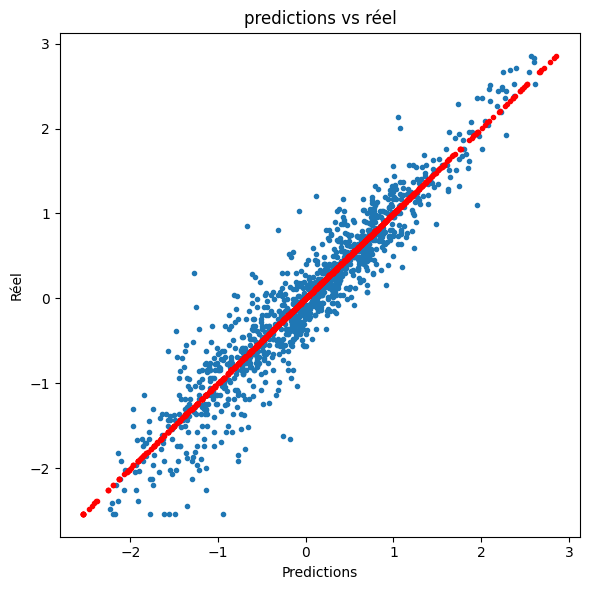

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

params = {'n_estimators':[44,109,314],
         'random_state':[45]}
FitModel(X,y,'Extra Tree',ExtraTreesRegressor(),params,cv=10)
